# Dependencies

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)
############ settings ############
data_dir = r"/Users/rachitkumar/Downloads/Potato-Disease-Classification-master/data"

batch_size = 32
img_height = 128
img_width = 128

2.19.0


# Data preprocessing

**- Loading and splitting data<br>**
**- Train:80% and Validation:20%**

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds= tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names
print("Class names found:",class_names)

os.makedirs("application/static/models", exist_ok=True)
with open("application/static/models/class_names.txt", "w") as f:
    for name in class_names:
        f.write(name + "\n")

Found 2982 files belonging to 3 classes.


Using 2386 files for training.
Found 2982 files belonging to 3 classes.
Using 596 files for validation.
Class names found: ['Early_blight', 'Healthy', 'Late_blight']


# EDA

2025-08-04 17:18:18.425360: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-04 17:18:18.594052: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


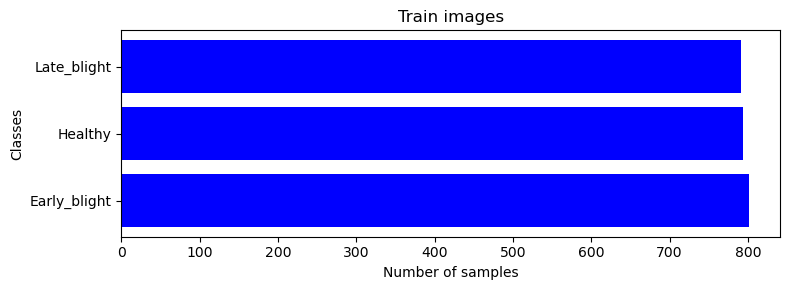

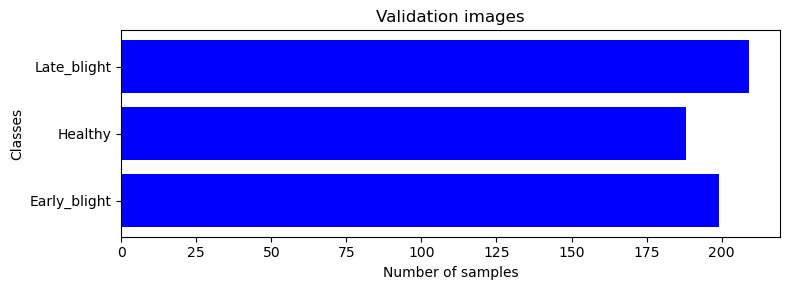

In [3]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(y, title):
    a = Counter(y)
    class_names = ['Early_blight', 'Healthy', 'Late_blight']
    x = [a[i] for i in range(3)]
    plt.figure(figsize=(8, 3))
    plt.barh(class_names, x, color='blue')
    plt.title(title)
    plt.xlabel("Number of samples")
    plt.ylabel("Classes")
    plt.tight_layout()
    plt.show()

# Convert datasets to list (this consumes them once)
train_data = list(train_ds)
val_data = list(val_ds)

# Extract labels
y_train = np.concatenate([y.numpy() for x, y in train_data], axis=0)
y_val = np.concatenate([y.numpy() for x, y in val_data], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title="Validation images") 

2025-08-04 17:18:19.465355: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


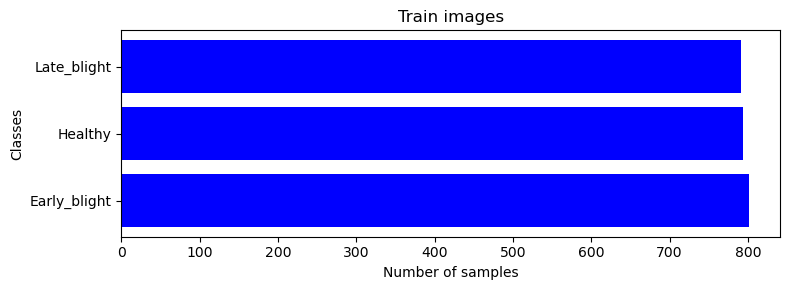

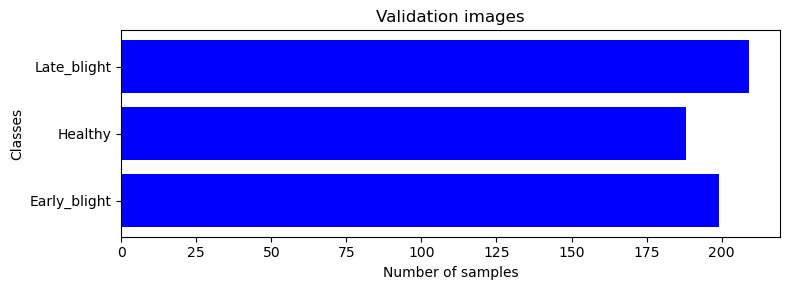

In [4]:
# Target distribution

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")

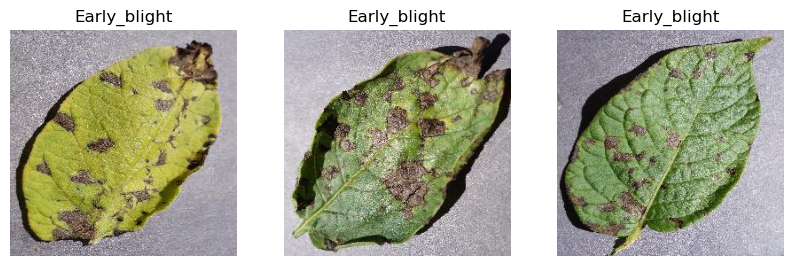

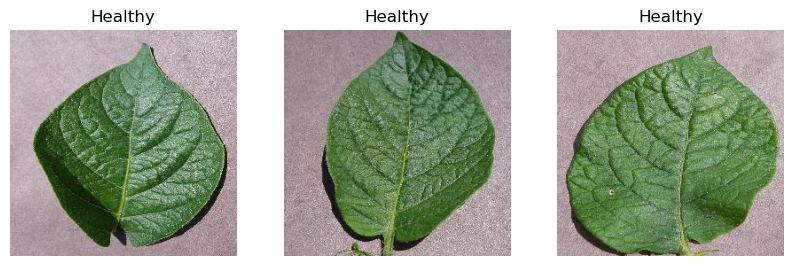

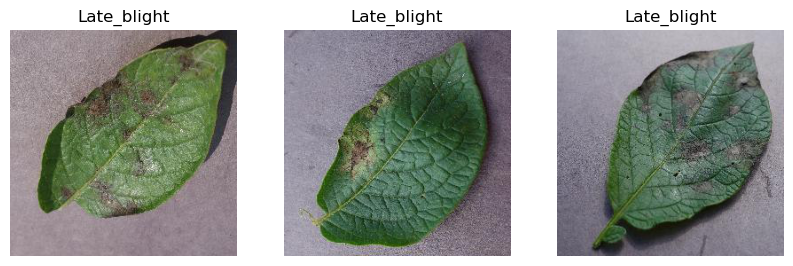

In [5]:
## Sample images
class_names = train_ds.class_names

for class_name in class_names:
    imgs = os.listdir(os.path.join(data_dir, class_name))[:3]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(os.path.join(data_dir, class_name, img)))
        plt.title(class_name)
        plt.axis('off')

# Model Training

In [6]:
# Configure the dataset for performance
from sklearn.utils import class_weight

y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train),
                                             y=y_train)
class_weights = dict(enumerate(weights))

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import (
    InputLayer, Rescaling, Conv2D, MaxPooling2D,
    Flatten, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Model setup
num_classes = 3

# Model architecture
model = model = tf.keras.Sequential([
    InputLayer(input_shape=(img_height, img_width, 3)),
    Rescaling(1./255),
    data_augmentation,

    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),

    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
earlystop_callback = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True
)

# Train model with class weights
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[earlystop_callback]
)

Epoch 1/20


/Users/rachitkumar/Desktop/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.5471 - loss: 0.9038 - val_accuracy: 0.8876 - val_loss: 0.2463
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8284 - loss: 0.4171 - val_accuracy: 0.9279 - val_loss: 0.1680
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9119 - loss: 0.2487 - val_accuracy: 0.9211 - val_loss: 0.2288
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9029 - loss: 0.2316 - val_accuracy: 0.9279 - val_loss: 0.1713
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9351 - loss: 0.1786 - val_accuracy: 0.8809 - val_loss: 0.3276
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9392 - loss: 0.1568 - val_accuracy: 0.9446 - val_loss: 0.1233
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9567 - loss: 0.1230 - val_accuracy: 0.9262 - val_loss: 0.2170
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9526 - loss: 0.1426 - val_accuracy: 0.9396 - val_loss: 0.

# Model Evaluation

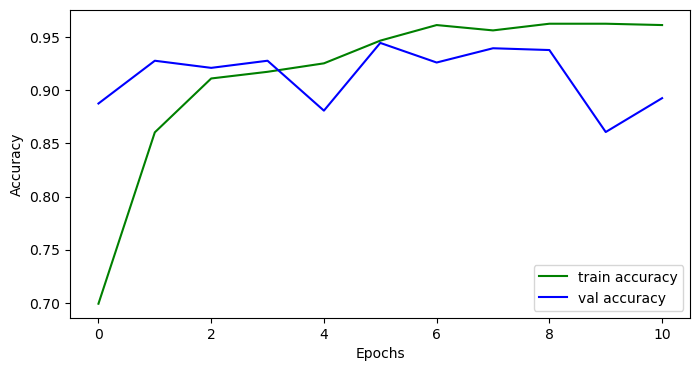

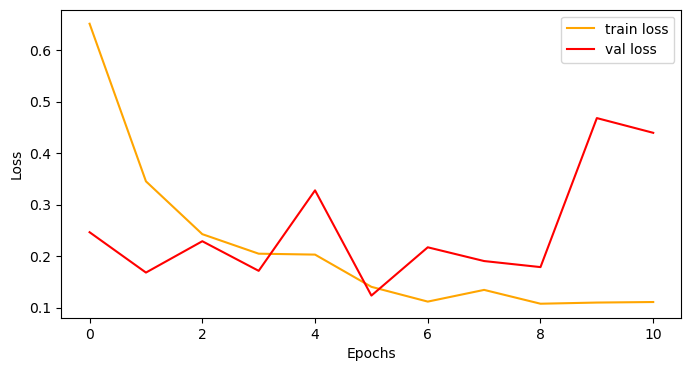

In [8]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
loss, acc = model.evaluate(val_ds, batch_size=batch_size)
print("validation accuracy :", round(acc, 2))
print("validation loss :", round(loss,2))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9352 - loss: 0.1355
validation accuracy : 0.94
validation loss : 0.12


In [10]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


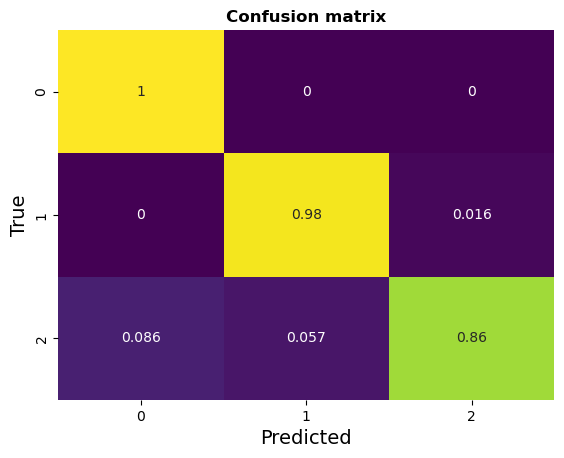

In [11]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

In [12]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       199
           1       0.94      0.98      0.96       188
           2       0.98      0.86      0.92       209

    accuracy                           0.94       596
   macro avg       0.95      0.95      0.94       596
weighted avg       0.95      0.94      0.94       596



# Post Processing

In [13]:
def prediction(img):
    class_names = ['Early_blight', 'Healthy', 'Late_blight']

    my_image = load_img(img, target_size=(img_height, img_width))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2], labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


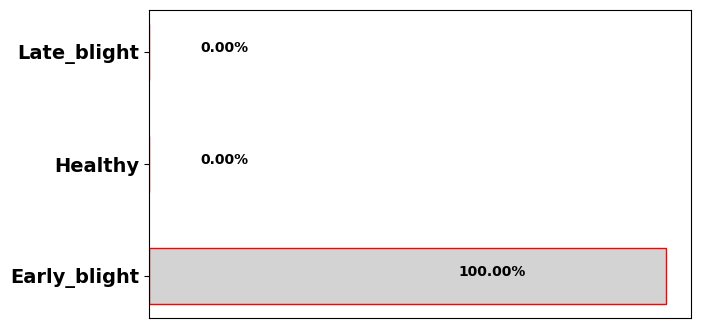

In [14]:
####### Prediction on single Image
img = '/Users/rachitkumar/Downloads/Potato-Disease-Classification-master/data/Early_blight/Test3.jpg'
prediction(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


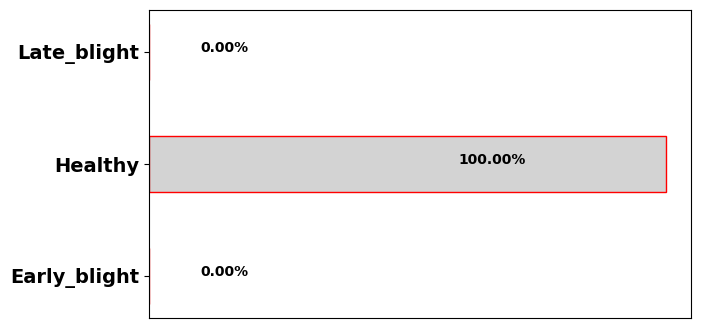

In [15]:
####### Prediction on single Image
img = '/Users/rachitkumar/Downloads/Potato-Disease-Classification-master/data/Healthy/Test2.jpg'
prediction(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


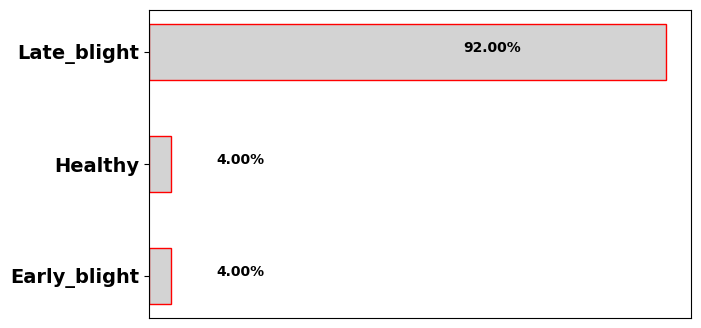

In [16]:
####### Prediction on single Image
img = '/Users/rachitkumar/Downloads/Potato-Disease-Classification-master/data/Late_blight/Test4.jpg'
prediction(img)

In [17]:
model.save("application/static/models/model_v1.keras")

In [18]:
os.makedirs("application/static/models", exist_ok=True)
print(os.path.abspath("application/static/models/model_v1.keras"))


/Users/rachitkumar/Downloads/Potato-Disease-Classification-master/application/static/models/model_v1.keras


In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the same image you upload in the web app
img_path = "/Users/rachitkumar/Downloads/Potato-Disease-Classification-master/data/Early_Blight/Test1.jpg"  # Replace with real path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]

print("Predicted class:", predicted_class)
print("All probabilities:", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: Late_blight
All probabilities: [[1.7014984e-02 4.6917279e-07 9.8298454e-01]]


In [20]:
from collections import Counter
import numpy as np

# Convert the training dataset to list
train_data = list(train_ds.unbatch().as_numpy_iterator())
labels = [label for _, label in train_data]
print(Counter(labels))

Counter({0: 801, 1: 794, 2: 791})


In [21]:
print(class_names)

['Early_blight', 'Healthy', 'Late_blight']


In [22]:
from collections import Counter
import numpy as np

# Convert the training dataset to list
train_data = list(train_ds.unbatch().as_numpy_iterator())
labels = [label for _, label in train_data]
print(Counter(labels))

Counter({0: 801, 1: 794, 2: 791})


2025-08-04 17:19:38.137246: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
